In [ ]:
# default_exp io

In [ ]:
# export
from fastscript import call_parse, Param, bool_arg
from scipy import ndimage

import h5py
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pydicom
import scipy.io as spio

# I2T2.io

> I2T2.io loads and saves common file formats used in medical imaging.

In [ ]:
# test
try:
    import gdcm
    print('Successfully imported GDCM')
except ImportError:
    print('Could not import GDCM')

Successfully imported GDCM


## load dicom

In [ ]:
# export
def load_dcm(path_to_dicom_dir=None, sort_by_image_position_patient=True, dicom_extension='.dcm'):
    """
    Loads DICOM data as a numpy array.

    Attributes:
        path_to_dicom_dir (str): Path to folder containing all dicom files for one subject
        sort_by_image_position_patient (bool): Whether to return array ordered by slice location
        dicom_extension (str): string used to search for files within directory (e.g.: .dcm, .DCM, MRDC)
    Returns:
        pixel_array (arr): Array of pixel data
    """
    try:
        import gdcm

    except ImportError:
        print("GDCM needs to be installed.")
        print("Try: conda install -c conda-forge gdcm")

    if not path_to_dicom_dir.endswith(('/')):
        path_to_dicom_dir = f"{path_to_dicom_dir}/"

    try:
        os.listdir(path_to_dicom_dir)

    except:
        print("path to dicom failed")

    else:
        df = pd.DataFrame()
        df['filename'] = os.listdir(path_to_dicom_dir)
        df['pathname'] = path_to_dicom_dir + df['filename']
        
        df = df[df['pathname'].str.contains(dicom_extension)]
        ImagePositionPatient = [] # Used to order/sort slices

        result = [] 
        df_ = pd.DataFrame(columns=['DS']) 
        for x in df["pathname"]:
            try:
                content = pydicom.dcmread(x)
            except:
                print('[WARNING] dicom.dcmread(x): Found a file in wrong format. Skipping...')
                continue
            result.append(content)
        df_["DS"] = result  
        df = df_        

        df['ImagePositionPatient'] = [x.ImagePositionPatient[0] for x in df['DS']]
        df['Pixels'] = [x.pixel_array for x in df['DS']]

        if sort_by_image_position_patient == True:
            df = df.sort_values(by=['ImagePositionPatient'])
        pixel_array = np.dstack(np.asarray(df['Pixels']))

        return pixel_array
    return None

### Usage

`dcm2array` takes a path to one DICOM series (patient).

See the example below:

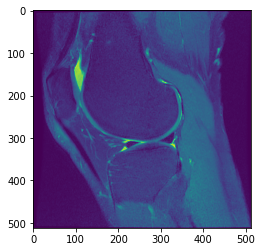

In [ ]:
#test

data_path = '../data/knee'
try:
    image_array = load_dcm(path_to_dicom_dir=data_path,
                           sort_by_image_position_patient=True)
    plt.imshow(image_array[:, :, 6])
    plt.show()
except:
    print('could not load array')

## Load .mat

In [ ]:
# export
def load_mat(path_to_mat_file=None, key='img'):
    """
    Loads matlab data as a numpy array.

    Attributes:
        path_to_mat_file (str): Path to mat file containing image / segmentation
        key (str): key to load from matlab dictionary

    Returns:
        pixel_array (arr): Array of pixel data
    """

    try:
        os.path.isfile(path_to_mat_file)

    except:
        print("mat file not found")

    else:
        pixel_array = spio.loadmat(path_to_mat_file)[key]

        return pixel_array
    return None

## Load .h5

In [ ]:
# export
def load_h5(path_to_h5_file=None):
    """
    Loads h5 files into numpy array.

    Attributes:
        path_to_h5_file (str): Path h5 file for one subject

    Returns:
        h5_file_dict (dict): Dictionary of pixel data
    """

    try:
        h5_file = h5py.File(path_to_h5_file, 'r')

    except:
        print("File", str(path_to_h5_file), "not found.")
        print("Make sure file exists")

    else:
        h5_file_dict = dict()
        keys = h5_file.keys()

        for k in keys:
            h5_file_dict[k] = h5_file.get(k)

        return(h5_file_dict)

### Usage

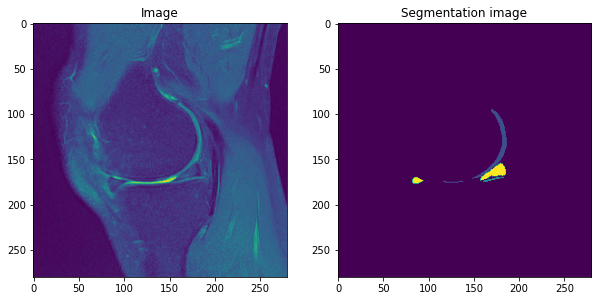

In [ ]:
h5_file = load_h5(
    path_to_h5_file='../data/knee-segmentation/knee_segmentation.h5')

# Plot
plt.figure(figsize=(10, 10))

plt.subplot(121)
plt.title('Image')
plt.imshow(h5_file['img'][:, :, 30])

plt.subplot(122)
plt.title('Segmentation image')
plt.imshow(h5_file['seg'][:, :, 30])

plt.show()